In [30]:
import pandas as pd
from category_encoders import (
    TargetEncoder,
)  # You might need to install this package
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import seaborn as sns

In [47]:
df = pd.read_csv("../../data/flightdata/balanced_flights_2022.csv")

In [48]:
# Define features and targets
X = df.drop(
    [
        "departureDelayMinutes",
        "arrivalDelayMinutes",
        "departureDelayBool",
        "arrivalDelayBool",
    ],
    axis=1,
)
y_reg = df[["departureDelayMinutes", "arrivalDelayMinutes"]]
y_clf = df[["departureDelayBool", "arrivalDelayBool"]]

In [49]:
# Split the data
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = (
    train_test_split(X, y_reg, y_clf, test_size=0.2, random_state=42)
)

In [50]:
# Preprocessing for numeric and categorical data
numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = ["originCode", "destinationCode"]  # Removed flightNumber

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", TargetEncoder(), categorical_features),
    ]
)

In [68]:
# Regression pipeline
reg_pipeline_departure = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

reg_pipeline_arrival = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [69]:
# Fit the models
reg_pipeline_departure.fit(X_train, y_reg_train["departureDelayMinutes"])
reg_pipeline_arrival.fit(X_train, y_reg_train["arrivalDelayMinutes"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['scheduledAirTime',
                                                   'distanceMiles', 'dayOfWeek',
                                                   'taxiOut', 'taxiIn',
                                                   'reliabilityScore',
                                                   'scheduledDepartureHour',
                                                   'scheduledArrivalHour',
                                                   'origin_precipitation_mm',
                                                   'origin_rain_mm',
                                                   'origin_snowfall_mm',
                                                   'origin_weather_code',
                                                   'origin_cloud_cover_percent',
                                                   'origin_wind_speed_kmh',
                                                   'origin_wind_direction_degrees',
                                                   'destination_precipitation_mm',
                                                   'destination_rain_mm',
                                                   'destination_snowfall_mm',
                                                   'destination_weather_code',
                                                   'destination_cloud_cover_percent',
                                                   'destination_wind_speed_kmh',
                                                   'destination_wind_direction_degrees']),
                                                 ('cat', TargetEncoder(),
                                                  ['originCode',
                                                   'destinationCode'])])),
                ('regressor', RandomForestRegressor())])

In [70]:
reg_departure_predictions = reg_pipeline_departure.predict(X_test)
reg_arrival_predictions = reg_pipeline_arrival.predict(X_test)

In [71]:
# Calculate RMSE for regression model
departure_rmse = ((reg_departure_predictions - y_reg_test["departureDelayMinutes"]) ** 2).mean() ** 0.5
arrival_rmse = ((reg_arrival_predictions - y_reg_test["arrivalDelayMinutes"]) ** 2).mean() ** 0.5

print(f"Departure RMSE: {departure_rmse}")
print(f"Arrival RMSE: {arrival_rmse}")

Departure RMSE: 74.18213657263009
Arrival RMSE: 73.47274832437701


In [72]:
# Calculate mean delay for test set
mean_departure_delay = y_reg_test["departureDelayMinutes"].mean()
mean_arrival_delay = y_reg_test["arrivalDelayMinutes"].mean()

# Use mean as a baseline model for comparison
baseline_departure_rmse = ((mean_departure_delay - y_reg_test["departureDelayMinutes"]) ** 2).mean() ** 0.5
baseline_arrival_rmse = ((mean_arrival_delay - y_reg_test["arrivalDelayMinutes"]) ** 2).mean() ** 0.5

print(f"Departure baseline RMSE: {baseline_departure_rmse}")
print(f"Arrival baseline RMSE: {baseline_arrival_rmse}")

Departure baseline RMSE: 73.95073738923303
Arrival baseline RMSE: 75.53060113359547


<Axes: ylabel='Count'>

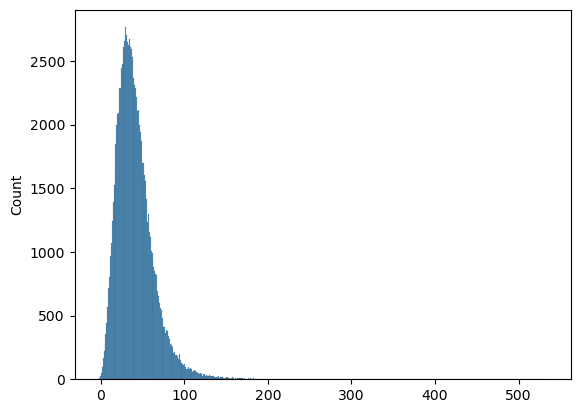

In [73]:
sns.histplot(reg_departure_predictions)

In [64]:
# Classification pipeline
clf_departure_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_samples=0.2, class_weight='balanced'))
])

clf_arrival_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_samples=0.2, class_weight='balanced'))
])

In [65]:
# Fit the models
clf_departure_pipeline.fit(X_train, y_clf_train["departureDelayBool"])
clf_arrival_pipeline.fit(X_train, y_clf_train["arrivalDelayBool"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['scheduledAirTime',
                                                   'distanceMiles', 'dayOfWeek',
                                                   'taxiOut', 'taxiIn',
                                                   'reliabilityScore',
                                                   'scheduledDepartureHour',
                                                   'scheduledArrivalHour',
                                                   'origin_precipitation_mm',
                                                   'origin_rain_mm',
                                                   'origin_snowfall_mm',
                                                   'origin_weather_code',
                                                   'origin_cloud_cover_percent',
                                                   'origin_wind_...
                                                   'origin_wind_direction_degrees',
                                                   'destination_precipitation_mm',
                                                   'destination_rain_mm',
                                                   'destination_snowfall_mm',
                                                   'destination_weather_code',
                                                   'destination_cloud_cover_percent',
                                                   'destination_wind_speed_kmh',
                                                   'destination_wind_direction_degrees']),
                                                 ('cat', TargetEncoder(),
                                                  ['originCode',
                                                   'destinationCode'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_samples=0.2))])

In [66]:
# Predict
clf_departure_predictions = clf_departure_pipeline.predict(X_test)
clf_arrival_predictions = clf_arrival_pipeline.predict(X_test)

In [67]:
# Evaluate f1 score and show confusion matrix
from sklearn.metrics import f1_score, confusion_matrix

f1_departure = f1_score(y_clf_test["departureDelayBool"], clf_departure_predictions)
f1_arrival = f1_score(y_clf_test["arrivalDelayBool"], clf_arrival_predictions)

print(f"Departure f1 score: {f1_departure}")
print(f"Arrival f1 score: {f1_arrival}")

confusion_matrix_departure = confusion_matrix(y_clf_test["departureDelayBool"], clf_departure_predictions)
confusion_matrix_arrival = confusion_matrix(y_clf_test["arrivalDelayBool"], clf_arrival_predictions)

print("Departure confusion matrix:")
print(confusion_matrix_departure)

print("Arrival confusion matrix:")
print(confusion_matrix_arrival)

Departure f1 score: 0.6092374735997095
Arrival f1 score: 0.6951622505414103
Departure confusion matrix:
[[39406 21884]
 [19005 31875]]
Arrival confusion matrix:
[[36554 17051]
 [18280 40285]]
